In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/MultiCampus/Project II

/content/drive/MyDrive/MultiCampus/Project II


In [ ]:
# Load Python libraries
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import kstest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skimage.transform import resize
import colorsys
from sklearn.cluster import KMeans
from collections import Counter
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings("ignore")
print(os.listdir('./pet_data'))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['train.csv', 'sample_submission.csv', 'test.csv', 'Untitled0.ipynb', 'duplicate_img.csv', 'cat_dog.csv', 'n_dog.csv', 'n_cat.csv', 'acc_cat.jpg', 'train 중복폴더 밖으로 빼놨습니다 잠깐', 'train', 'original_train', 'original_test', 'train_copy_full', 'cat_dog_full', 'group_cat.jpg', '2_dog.jpg', 'test', 'dog_cat_1.h5', 'dog_cat_2.h5']


In [ ]:
# csv 파일 읽기 
path = './pet_data/'
train_df = pd.read_csv(path+'train.csv')
test_df = pd.read_csv(path+'test.csv')

In [ ]:
# train 파일 
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [ ]:
# train 이미지 개수 확인
print(f"Number of images in Train set : {train_df.shape[0]}")

Number of images in Train set : 9912


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


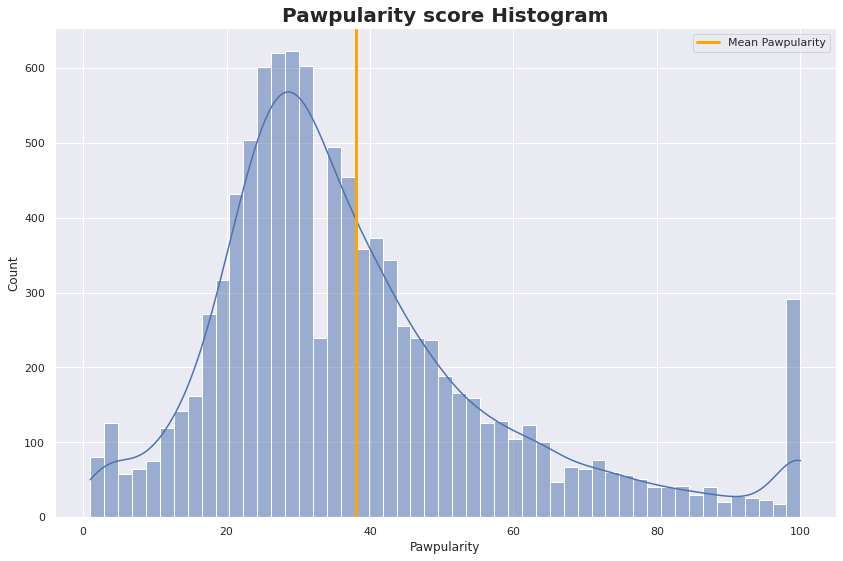

In [ ]:
# train 데이터 분포 확인 
sns.set(rc={'figure.figsize':(14,9)})
fig = plt.figure()
sns.histplot(data=train_df, x='Pawpularity', kde=True)
plt.axvline(train_df['Pawpularity'].mean(), c='orange', ls='-', lw=3, label="Mean Pawpularity")
plt.title('Pawpularity score Histogram', fontsize=20, fontweight='bold')
plt.legend()
plt.show()

- 20~40 점수대가 가장 많음. 

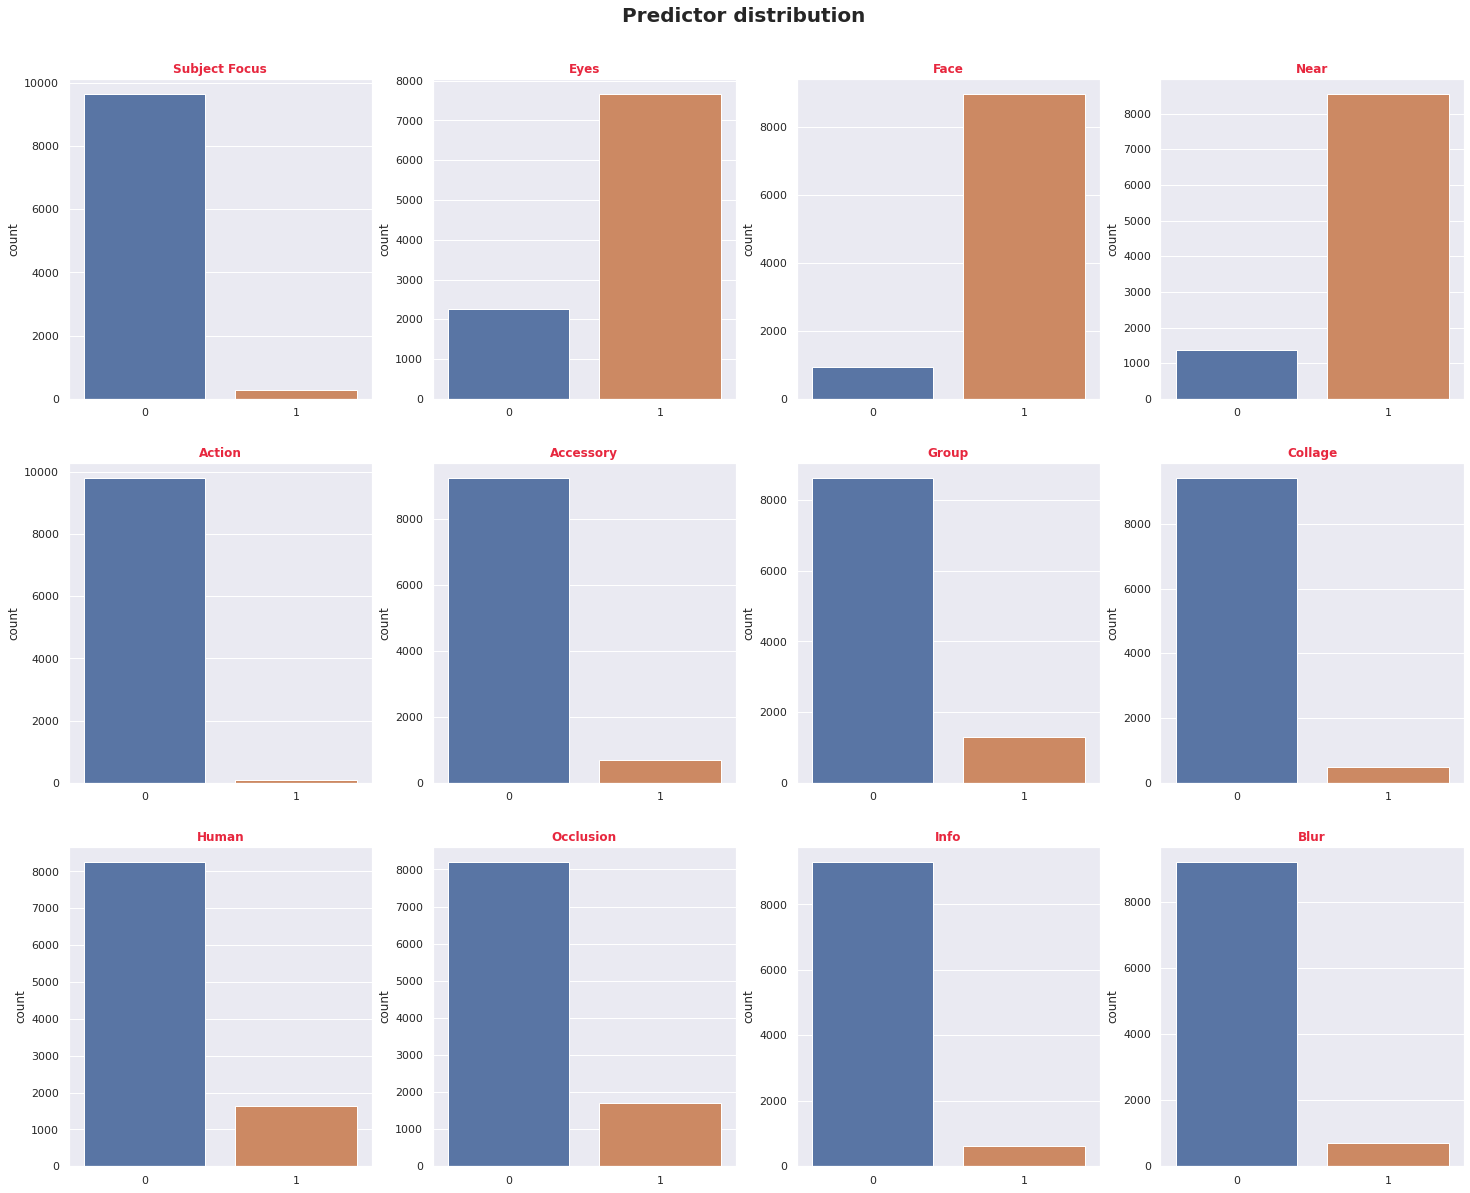

In [ ]:
# 예측 변수 분포 확인 (distribution of the predictor variables)
predictor = train_df.columns[1:-1]

fig = plt.figure(figsize=(25,20))
for i, x in enumerate(predictor):
    ax = plt.subplot(3,4,i+1)
    sns.countplot(data=train_df, x=x, ax=ax)
    ax.set_xlabel(None)
    ax.set_title(x, fontweight='bold', color="#e7273e")

plt.suptitle("Predictor distribution", y=0.93,
             fontsize=20, fontweight='bold')
plt.show()  

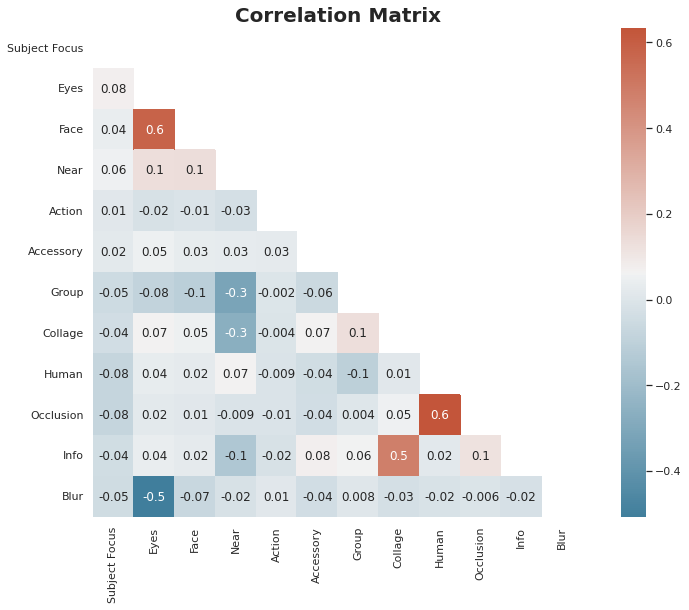

In [ ]:
# 변수끼리의 상관도 측정 (correlations between predictor variables)
corr_matrix = train_df[predictor].corr()
fig = plt.figure()
sns.set_theme(style="white")
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap=cmap, 
            mask=mask, square=True)
plt.title('Correlation Matrix', fontsize=20, fontweight='bold')
plt.show()

주요 상관도(>0.5) 2개 보임 
- The first between Occlusion and Human (Humans can hide part of the animal) : 사람의 동물 뒤에 있거나 가릴 때 
- The second between Face and Eyes which this time may seem logical. : 정면일 때와 눈이 명확하게 보일 때

In [ ]:
# VIF dataframe
vif_data = pd.DataFrame()
X = train_df[predictor]
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]  
vif_data = vif_data.sort_values("VIF", ascending=False)
vif_data

,feature,VIF
2,Face,13.715668
1,Eyes,10.118170
3,Near,5.762924
9,Occlusion,2.073562
8,Human,2.064939
11,Blur,1.595109
7,Collage,1.452023
10,Info,1.412621
6,Group,1.163850
5,Accessory,1.090942


As we can see, Face and Eyes have very high values of VIF, indicating that these two variables are highly correlated. Hence, considering these two features together leads to a model with high multicollinearity. We will therefore use only one of these 2 variables for the modelizations.

We remove the variable that has the highest VIF.

In [ ]:
# X.drop("Face", axis=1, inplace=True)
X.columns

Index(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group',
       'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],
      dtype='object')

In [ ]:
# 예측변수와 인기도 상관도 
print("-"*80)
print("Pearson correlation with Pawpularity (y)")
print("-"*80)
for x in X.columns:
    corr_y = round(np.corrcoef(train_df[x], train_df["Pawpularity"])[0,1],4)
    print(f"Pawpularity / {x}: {corr_y}")
print("-"*80)

--------------------------------------------------------------------------------
Pearson correlation with Pawpularity (y)
--------------------------------------------------------------------------------
Pawpularity / Subject Focus: -0.0099
Pawpularity / Eyes: -0.0067
Pawpularity / Face: 0.008
Pawpularity / Near: 0.001
Pawpularity / Action: -0.0014
Pawpularity / Accessory: 0.0133
Pawpularity / Group: 0.0165
Pawpularity / Collage: 0.0017
Pawpularity / Human: 0.004
Pawpularity / Occlusion: 0.002
Pawpularity / Info: -0.0047
Pawpularity / Blur: -0.0235
--------------------------------------------------------------------------------


FileNotFoundError: ignored

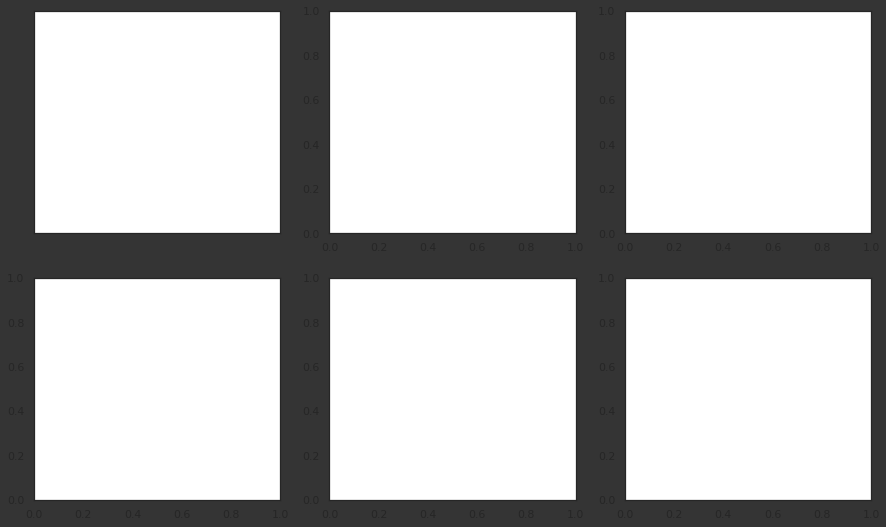

In [ ]:
# 샘플이미지 확인
fig, ax = plt.subplots(2,3,figsize=(15,9))
fig.patch.set_facecolor('#343434')

for i, a in zip(train_df[['Id', 'Pawpularity']].sample(6).iterrows(), ax.ravel()):
    a.set(xticks=[], yticks=[])
    img = plt.imread('./train/'+ i[1][0] + ".jpg")
    a.imshow(img)
    a.set_title(f'Id: {i[0]}, Pawpularity Score: {i[1][1]}', color="white")

fig.suptitle('Pawpularity Images', fontsize=20, fontweight='bold', color="#e7273e")
fig.tight_layout()
fig.show()

At the moment, it seems difficult to understand the difference between images that have a high popularity and those that do not win many votes. We also see that the orientations and sizes of images are different.
We will now look at the differences between the predictor variables at 0 or 1.

In [ ]:
fig, ax = plt.subplots(11, 2, figsize=(14,50))
fig.patch.set_facecolor('#343434')

for a in ax.ravel():
    a.set(xticks=[], yticks=[])

for r in range(11):
    label = X.columns[r]
    for i in [0, 1]:
        img_id = train_df[train_df[label] == i].sample()['Id'].values[0]
        img = plt.imread(PATH + f"/train/{img_id}.jpg")
        ax[r, i].imshow(img)
        ax[r, i].set_title(f'{label}={i}', color="white")

fig.tight_layout()
fig.show()

Finally, we will project the top 3 most popular and least popular images to see if the difference is marked and humanly understandable.

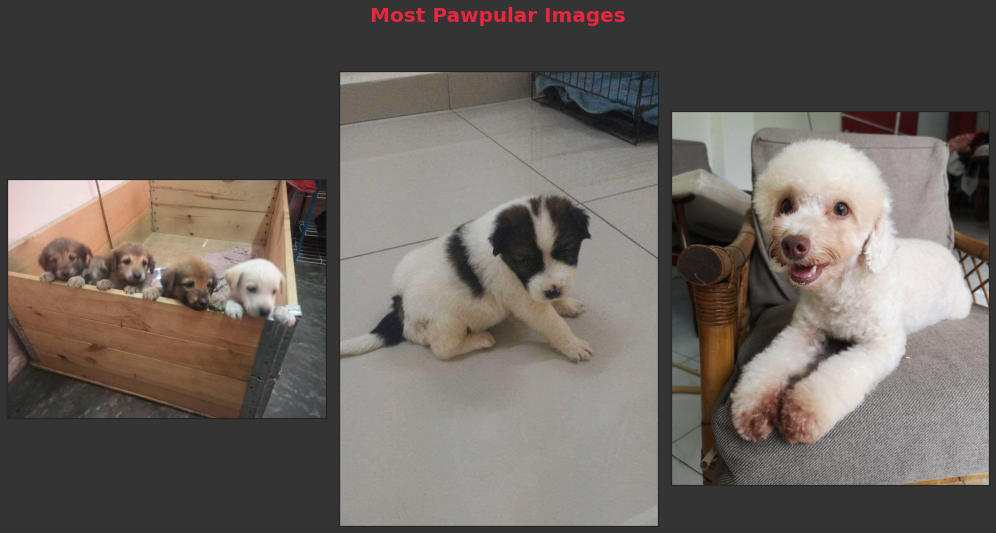

In [ ]:
# 각각 3개의 상위/하위 이미지 - 어떤 차이가 있는지 
top = train_df[train_df['Pawpularity'] == 100]['Id']

fig, ax = plt.subplots(1,3)
fig.patch.set_facecolor('#343434')

for i, ax in zip(top.sample(3), ax.ravel()):
    ax.set(xticks=[], yticks=[])
    img = plt.imread(PATH + f"/train/{i}.jpg")
    ax.imshow(img)
    
fig.suptitle('Most Pawpular Images', fontsize=20, fontweight='bold', color='#e7273e', y=0.95)
fig.tight_layout()
fig.show()

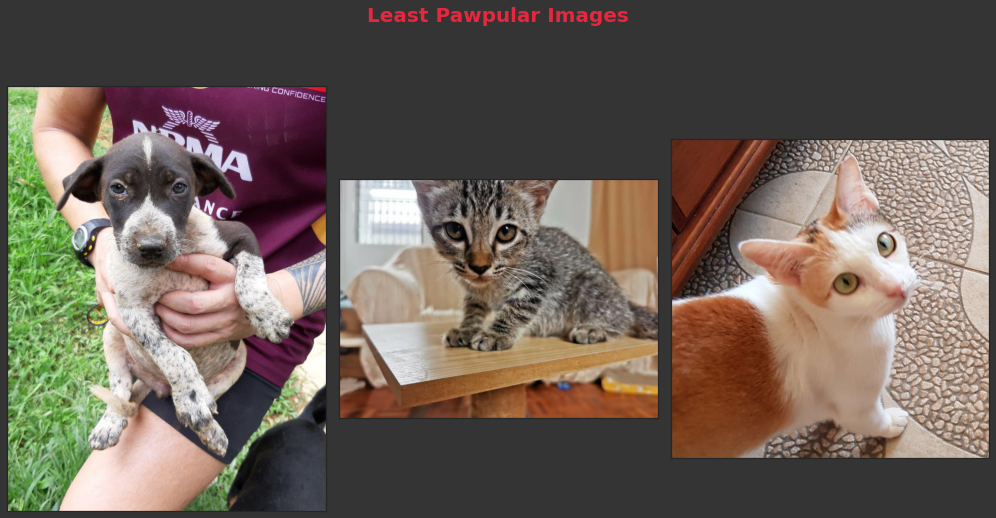

In [ ]:
bottom = train_df[train_df['Pawpularity'] == 1]['Id']

fig, ax = plt.subplots(1,3)
fig.patch.set_facecolor('#343434')

for i, ax in zip(bottom.sample(3), ax.ravel()):
    ax.set(xticks=[], yticks=[])
    img = plt.imread(PATH + f"/train/{i}.jpg")
    ax.imshow(img)
    
fig.suptitle('Least Pawpular Images', fontsize=20, fontweight='bold', color='#e7273e', y=0.95)
fig.tight_layout()
fig.show()

----------어떤 차이가 있는지 구별하기 어려움 ----------

### Extract dominant color of each image with KMeans
Some photography experts agree that the dominant color of an image can unconsciously affect its popularity (as well as overall exposure for that matter). We are therefore going to create a variable that will store the dominant color of each image.
<br>
To do this, we will use clustering methods on the RGB layers of our jpg files to extract the dominant color in HLS (Hue Lightness Saturation) format. This format will allow us to recover in a single formula the information on the hue, saturation and luminance of the dominant color of each image.

In [ ]:
#  주요 컬러 뽑아내는 함수 정의 
def get_dominant_color(image_path, k=4, image_processing_size = None):
    """
    takes an image as input
    returns the dominant color of the image as a list
    
    dominant color is found by running k means on the 
    pixels & returning the centroid of the largest cluster

    processing time is speed up by working with a smaller image; 
    this resizing can be done with the image_processing_size param 
    which takes a tuple of image dims as input
    """
    
    image = plt.imread(image_path)
    #resize image if new dims provided
    if image_processing_size is not None:
        image = cv2.resize(image, image_processing_size, 
                            interpolation = cv2.INTER_AREA)
    
    #reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    #cluster and assign labels to the pixels 
    clt = KMeans(n_clusters = k)
    labels = clt.fit_predict(image)

    #count labels to find most popular
    label_counts = Counter(labels)

    #subset out most popular centroid
    dominant_color = clt.cluster_centers_[label_counts.most_common(1)[0][0]]
    dominant_color = list(dominant_color)
    r = int(dominant_color[0])
    g = int(dominant_color[1])
    b = int(dominant_color[2])
    
    #Convert to HLS color space
    dominant_hls = colorsys.rgb_to_hls(r, g, b)

    return list(dominant_hls)

Dominant HLS :  [0.6666666666666666, 73.5, -0.006896551724137931]
Dominant Color Hex :  #49494a


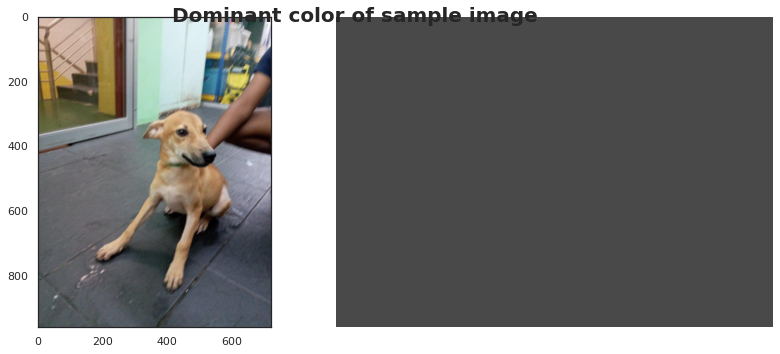

In [ ]:
# 이미지 경로 
TRAIN_PATH = './pet_data/train/'
TEST_PATH = './pet_data/test/'

# 샘플 이미지 확인
sample_img = TRAIN_PATH+"0095f81bab3b68a4f70e99f0fcec7b06.jpg"
sample_hls = get_dominant_color(sample_img, k=3, image_processing_size = (50, 50))
sample_dom_color = colorsys.hls_to_rgb(sample_hls[0],
                                       sample_hls[1],
                                       sample_hls[2])
sample_dom_color = "#{:02x}{:02x}{:02x}".format(int(sample_dom_color[0]),
                                                int(sample_dom_color[1]),
                                                int(sample_dom_color[2]))
print("Dominant HLS : ", sample_hls)
print("Dominant Color Hex : ", sample_dom_color)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax = plt.imshow(plt.imread(sample_img))
ax2 = fig.add_subplot(122)
rect1 = matplotlib.patches.Rectangle((0,0), 10, 5,color=sample_dom_color)
ax2.add_patch(rect1)
plt.axis('off')
plt.suptitle('Dominant color of sample image', fontsize=20, fontweight='bold', y=0.98)
fig.tight_layout()
plt.show()

In [ ]:
# 데이터셋에 적용해보기 
tqdm.pandas()
train_df["Dominant_color_hls"] = train_df["Id"].progress_apply(
    lambda x : get_dominant_color(
        TRAIN_PATH+x+".jpg", 
        k=3, 
        image_processing_size = (50, 50)))

  0%|          | 0/9912 [00:00<?, ?it/s]

In [ ]:
HLS_train_df = train_df["Dominant_color_hls"].apply(pd.Series)
HLS_train_df = HLS_train_df.rename(columns={0:"H",1:"L",2:"S"})
train_df = pd.concat([train_df, HLS_train_df], axis=1)
train_df.drop("Dominant_color_hls", axis=1, inplace=True)
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,H,L,S
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,0.083333,174.0,-0.011561
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,0.055556,48.0,-0.255319
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,0.493333,85.0,-0.297619
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,0.092593,154.5,-0.029316
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,0.083333,136.0,-0.044444


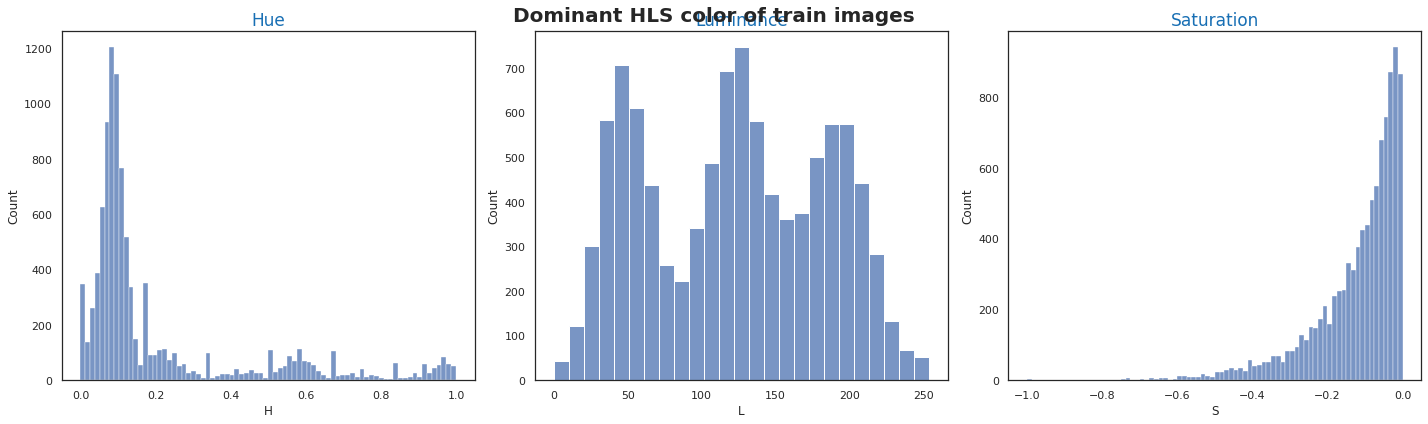

In [ ]:
# hue: 색상(0-1범위: 0어두움 1밝음)
# luminance: 휘도(빛이 반사되서 보이는 반사면의 밝기, 눈부심 정도)
# saturation:채도(0에가까울수록 흰색)
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(131)
sns.histplot(train_df["H"], ax=ax1)
ax1.set_title("Hue", fontsize=17, color="#186fb4")
ax2 = fig.add_subplot(132)
sns.histplot(train_df["L"], ax=ax2)
ax2.set_title("Luminance", fontsize=17, color="#186fb4")
ax3 = fig.add_subplot(133)
sns.histplot(train_df["S"], ax=ax3)
ax3.set_title("Saturation", fontsize=17, color="#186fb4")
plt.suptitle('Dominant HLS color of train images', 
             fontsize=20, fontweight='bold', y=0.98)
fig.tight_layout()
plt.show()

In [ ]:
# test
test_df.head()
test_df.tail()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0
5,b03f7041962238a7c9d6537e22f9b017,0,0,1,1,1,1,1,1,1,0,1,0
6,c978013571258ed6d4637f6e8cc9d6a3,1,0,0,0,1,1,0,1,0,1,1,1
7,e0de453c1bffc20c22b072b34b54e50f,1,0,1,0,0,0,0,0,1,0,0,1


In [ ]:
TEST_PATH = './pet_data/test/'
test_df["Dominant_color_hls"] = test_df["Id"].progress_apply(
    lambda x : get_dominant_color(
        TEST_PATH+x+".jpg", 
        k=3, 
        image_processing_size = (50, 50)))

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
HLS_test_df = test_df["Dominant_color_hls"].apply(pd.Series)
HLS_test_df = HLS_test_df.rename(columns={0:"H",1:"L",2:"S"})
test_df = pd.concat([test_df, HLS_test_df], axis=1)
test_df.drop("Dominant_color_hls", axis=1, inplace=True)
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,H,L,S
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1,0.949495,133.5,-0.124528
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0,0.063492,115.5,-0.091703
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1,0.212963,113.0,-0.080357
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0,0.122222,112.5,-0.067265
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0,0.012346,136.5,-0.099631


- 원본 이미지 resolution

In [ ]:
os.listdir(path)

['train.csv',
 'sample_submission.csv',
 'test.csv',
 'test',
 'train',
 'Untitled0.ipynb',
 'cat_dog.csv']

Define final Dataset for training
- For the variable to be predicted (y = Pawpularity), we are going to reduce its value between 0 and 1 so that they are more understandable for the models.

In [ ]:
ids = train_df[["Id"]].values
y = np.ravel(train_df[["Pawpularity"]]/100)
X = train_df.drop(["Id", "Pawpularity"], axis=1)
X_test = test_df.drop("Id", axis=1)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=42)

print("-"*80)
print("Train and test split sizes")
print("-"*80)
print(f"X_train : {X_train.shape}")
print(f"X_test : {X_valid.shape}")
print(f"y_train : {y_train.shape[0]}")
print(f"y_test : {y_valid.shape[0]}")
print("-"*80)

--------------------------------------------------------------------------------
Train and test split sizes
--------------------------------------------------------------------------------
X_train : (6938, 12)
X_test : (2974, 12)
y_train : 6938
y_test : 2974
--------------------------------------------------------------------------------


In [ ]:
rfr = RandomForestRegressor(random_state=8)
param_grid = {
            "n_estimators" : [10,50,100],
            "max_features" : ["log2", "sqrt"],
            "max_depth"    : [5,15,25],
            "bootstrap"    : [True, False]
        }

grid_rfr = GridSearchCV(
    rfr,
    param_grid,
    cv = 5,
    verbose=1,
    n_jobs=-1)

best_rfr = grid_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   21.8s finished


In [ ]:
# GridSearch CV 후 best parameters 추출
print("-"*80)
print("Best parameters for Random Forest model")
print("-"*80)
print(best_rfr.best_params_)
print("-"*80)

--------------------------------------------------------------------------------
Best parameters for Random Forest model
--------------------------------------------------------------------------------
{'bootstrap': True, 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
--------------------------------------------------------------------------------


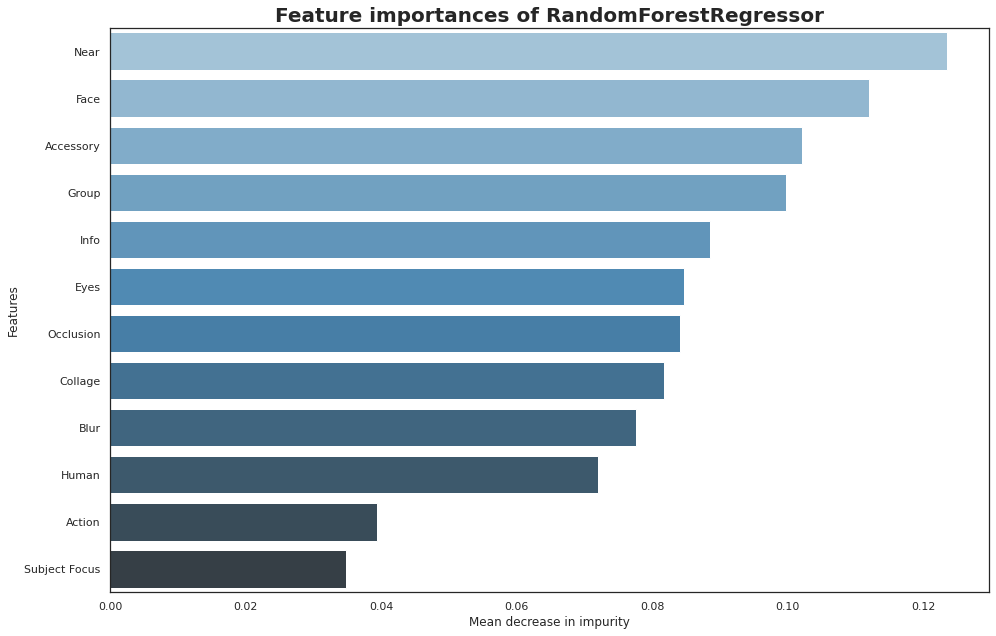

In [ ]:
# 중요한 feature 값 
importances = best_rfr.best_estimator_.feature_importances_

feature_names = X_train.columns
forest_importances = pd.DataFrame(importances, columns=["FI"], index=feature_names)
forest_importances = forest_importances.sort_values("FI", ascending=False)

fig, ax = plt.subplots()
sns.barplot(data=forest_importances, x = "FI", 
            y=forest_importances.index, ax=ax, 
            palette="Blues_d")
ax.set_title("Feature importances of RandomForestRegressor", 
             fontsize=20, fontweight='bold')
ax.set_xlabel("Mean decrease in impurity")
ax.set_ylabel("Features")
fig.tight_layout()